# Similarity computation

In [9]:
# imports
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from itertools import product
import numpy as np

#### Goal of the Similarity Analysis: Similarity assessment to enable users to compare pairs of counties. This comparison will help in evaluating how closely related two counties are, providing a basis for understanding the extent of similarities and differences across various attributes.

``` MARKDOWN
Network Graph Computation pipeline including: data preparation, computation, and visualization steps to create an insightful similarity network graph and enhance user analysis capabilities.

Data Merging:
Merged the inflow and outflow migration datasets by grouping on state and county.
Cleaned the house price dataset and merged it with the migration data.
Processed the health dataset by removing non-numeric columns that required further processing. Only kept columns in the correct format and merged this with the migration and house price data to create a unified dataset.

Data Preprocessing

Feature Scaling:
Scaled all numeric attributes in the dataset to normalize the data for similarity computation.
Pairwise County Data Creation:

Created all possible county pairs for the dataset (pairwise data). With around 3,000 counties, this produced approximately 9 million pairs for analysis.
Similarity Matrix Calculation on AWS:

Due to the large data size, the similarity matrix computation will be performed on AWS. The plan is to use an EMR cluster and an S3 bucket to compute the similarity matrix efficiently.
The output will be a similarity measure for each county pair, which could be visualized in Tableau:

 In Tableau to allow users to select a county and view how other counties relate to it in terms of similarity. The similarity metric will be reflected in color intensity—darker colors indicate higher similarity, while lighter colors show lower similarity.

Network Graph Visualization:
The network visualization aims to provide insight into county clusters with similar attributes and high interaction. This clustered view in NetworkX complements Tableau’s map view, offering a clear picture of county relationships and similarities.
For network visualization of strong similarities (e.g., similarity > 0.7), we’ll use NetworkX to create clusters of highly similar counties that are not in the same State. This graph will help understand the relationship between counties, allowing users to see interconnected clusters.


Next steps:
Recalculate and refine the pricing index to improve accuracy for house price analysis.
replace housinhg and health with updated csv from EDA step.

## Data Preparation

In [7]:
# import data
data = pd.read_csv('/Users/judithyemeli/Documents/CSE_6242/Project/MVR/network_graph/inputs_data/similarity_attributes.csv')
print(len(data))
data.head()

3054


,num_returns,num_individuals,adjusted_gross_income,current_house_price_2024,price_index,temperature,fair_poor,physically_unhealthy_days,mentally_unhealthy_days,smokers,obese,physically_inactive,excessive_drinking,some_college,population_1,social_associations,severe_housing_problems,id
0,1157.678261,2613.026087,73080.478261,239900.8779,119.895294,66.8,19.0,4.36,4.48,18.6,34.8,31.4,15.6,8765.4,14370.6,71.6,14.8,AL_1
1,2318.377990,4804.588517,165935.966507,387625.9624,136.772357,70.7,17.2,3.94,4.30,17.6,29.6,24.6,17.2,31604.2,48264.6,225.0,14.0,AL_3
2,488.840426,1026.468085,21870.553191,143559.7134,127.522538,67.2,27.4,5.20,4.96,23.0,43.0,28.6,12.6,2579.8,6918.6,20.6,15.0,AL_5
3,506.294872,1136.474359,27152.615385,188344.7208,123.796660,66.2,20.6,4.54,4.58,20.4,38.2,34.8,15.4,2894.6,6211.4,21.6,11.2,AL_7
4,1099.470588,2524.274510,61169.490196,224539.7875,128.134665,64.9,21.0,4.68,4.84,20.6,34.4,29.8,14.8,7531.2,14020.6,49.2,10.8,AL_9


In [8]:
# scale data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.drop('id', axis=1))

In [10]:
def create_county_pairs_chunked(df, id_col='county_id', scaled_data=None, chunk_size=100000):
    """
    Creates a DataFrame of all possible pairs of counties with their respective data and similarity scores in chunks.

    Parameters:
    - df (pd.DataFrame): The original DataFrame with county data.
    - id_col (str): The column name for the county identifier (default is 'county_id').
    - scaled_data (np.array): Scaled data array for similarity calculation, with each row corresponding to a county.
    - chunk_size (int): The number of pairs to process per chunk.

    Returns:
    - pd.DataFrame: A DataFrame with all unique pairs of counties, their data, and similarity scores.
    """
    # Prepare all possible pairs of counties
    pairs = pd.DataFrame(list(product(df[id_col], df[id_col])), columns=[f'{id_col}_1', f'{id_col}_2'])
    pairs = pairs[pairs[f'{id_col}_1'] != pairs[f'{id_col}_2']].reset_index(drop=True)
    
    # Calculate cosine similarity matrix once for all pairs
    similarity_matrix = cosine_similarity(scaled_data)
    
    # Map county IDs to their indices in the scaled data
    id_to_index = {county: i for i, county in enumerate(df[id_col])}
    
    # Add indices to the pairs DataFrame
    pairs['idx_1'] = pairs[f'{id_col}_1'].map(id_to_index)
    pairs['idx_2'] = pairs[f'{id_col}_2'].map(id_to_index)
    
    # Chunk processing
    result_chunks = []
    num_pairs = pairs.shape[0]
    for start in range(0, num_pairs, chunk_size):
        end = min(start + chunk_size, num_pairs)
        
        # Select the current chunk
        chunk = pairs.iloc[start:end].copy()
        
        # Calculate similarity for the chunk by indexing into the similarity matrix
        chunk['similarity'] = chunk.apply(lambda x: similarity_matrix[x['idx_1'], x['idx_2']], axis=1)
        
        # Drop index columns to keep only relevant data
        chunk = chunk[[f'{id_col}_1', f'{id_col}_2', 'similarity']]
        
        # Append chunk result to list
        result_chunks.append(chunk)
    
    # Concatenate all chunks into a single DataFrame
    result_df = pd.concat(result_chunks, ignore_index=True)
    
    return result_df

In [22]:
# Assuming df is your original DataFrame and scaled_data is your scaled data
pairs_with_similarity = create_county_pairs_chunked(df=data, id_col='id', scaled_data=scaled_data)

In [23]:
pairs_with_similarity.head()

,id_1,id_2,similarity
0,AL_1,AL_3,0.210830
1,AL_1,AL_5,0.621211
2,AL_1,AL_7,0.732553
3,AL_1,AL_9,0.742840
4,AL_1,AL_11,0.627043


In [89]:
len(pairs_with_similarity)

9323862

In [24]:
pairs_with_similarity['id_1'] = pairs_with_similarity['id_1'].apply(lambda x: x[:3] + '00' + x[3:])
pairs_with_similarity['id_2'] = pairs_with_similarity['id_2'].apply(lambda x: x[:3] + '00' + x[3:])

In [25]:
pairs_with_similarity

,id_1,id_2,similarity
0,AL_001,AL_003,0.210830
1,AL_001,AL_005,0.621211
2,AL_001,AL_007,0.732553
3,AL_001,AL_009,0.742840
4,AL_001,AL_0011,0.627043
...,...,...,...
9323857,WY_0045,WY_0035,0.797889
9323858,WY_0045,WY_0037,0.785024
9323859,WY_0045,WY_0039,0.113217
9323860,WY_0045,WY_0041,0.772974


In [26]:
labels = pd.read_csv('/Users/judithyemeli/Documents/CSE_6242/Project/MVR/network_graph/code/labels.csv')
labels.head()

,id_A,county_code_A,county_name_A,state_code_A,state_name_A
0,AL_001,1,Autauga County,1,Alabama
1,AL_003,3,Baldwin County,1,Alabama
2,AL_005,5,Barbour County,1,Alabama
3,AL_007,7,Bibb County,1,Alabama
4,AL_009,9,Blount County,1,Alabama


In [39]:
labels_B = labels.copy()
labels_B.columns = labels_B.columns.str.replace('_A', '_B')
labels_B

,id_B,county_code_B,county_name_B,state_code_B,state_name_B
0,AL_001,1,Autauga County,1,Alabama
1,AL_003,3,Baldwin County,1,Alabama
2,AL_005,5,Barbour County,1,Alabama
3,AL_007,7,Bibb County,1,Alabama
4,AL_009,9,Blount County,1,Alabama
...,...,...,...,...,...
2349,nan_145,145,Vega Baja Municipio,72,Puerto Rico
2350,nan_147,147,Vieques Municipio,72,Puerto Rico
2351,nan_149,149,Villalba Municipio,72,Puerto Rico
2352,nan_151,151,Yabucoa Municipio,72,Puerto Rico


In [40]:
merged_A = pairs_with_similarity.merge(labels, left_on='id_1', right_on='id_A')


In [41]:
merged_B = merged_A.merge(labels_B, left_on='id_2', right_on='id_B')

In [42]:
merged_B.head()

,id_1,id_2,similarity,id_A,county_code_A,county_name_A,state_code_A,state_name_A,id_B,county_code_B,county_name_B,state_code_B,state_name_B
0,WV_001,WV_005,0.982010,WV_001,1,Barbour County,54,West Virginia,WV_005,5,Boone County,54,West Virginia
1,WV_005,WV_001,0.982010,WV_005,5,Boone County,54,West Virginia,WV_001,1,Barbour County,54,West Virginia
2,AR_003,MS_003,0.979938,AR_003,3,Ashley County,5,Arkansas,MS_003,3,Alcorn County,28,Mississippi
3,MS_003,AR_003,0.979938,MS_003,3,Alcorn County,28,Mississippi,AR_003,3,Ashley County,5,Arkansas
4,IA_009,IA_001,0.977880,IA_009,9,Audubon County,19,Iowa,IA_001,1,Adair County,19,Iowa


In [16]:
# mapping_df = pd.read_csv('/Users/judithyemeli/Documents/CSE_6242/Project/MVR/network_graph/inputs_data/mapping_df.csv')
# mapping_df.head()

In [48]:
merged_B  = merged_B.sort_values('similarity', ascending=False)

In [ ]:
categories = ['very similar', 'similar',  'somewhat similar', 'different']
ranges = [0.9, 0.7, 0.5, 0.3, 0]

In [69]:
# Define the categories and ranges in ascending order
categories_ranges = {
    'not similar': 0,
    'somewhat similar': 0.5,
    'similar': 0.7,
    'very similar': 0.9
}

# Ensure bins are in ascending order
ranges = sorted(categories_ranges.values())
categories = [k for k, v in sorted(categories_ranges.items(), key=lambda item: item[1])]

# Add the "category" column based on the similarity values
merged_B['category'] = pd.cut(merged_B['similarity'], bins=ranges + [1], labels=categories, right=False)


In [70]:
merged_B.head()

,id_1,id_2,similarity,id_A,county_code_A,county_name_A,state_code_A,state_name_A,id_B,county_code_B,county_name_B,state_code_B,state_name_B,category
1,WV_005,WV_001,0.982010,WV_005,5,Boone County,54,West Virginia,WV_001,1,Barbour County,54,West Virginia,very similar
0,WV_001,WV_005,0.982010,WV_001,1,Barbour County,54,West Virginia,WV_005,5,Boone County,54,West Virginia,very similar
2,AR_003,MS_003,0.979938,AR_003,3,Ashley County,5,Arkansas,MS_003,3,Alcorn County,28,Mississippi,very similar
3,MS_003,AR_003,0.979938,MS_003,3,Alcorn County,28,Mississippi,AR_003,3,Ashley County,5,Arkansas,very similar
4,IA_009,IA_001,0.977880,IA_009,9,Audubon County,19,Iowa,IA_001,1,Adair County,19,Iowa,very similar


In [86]:
merged_B = merged_B.drop_duplicates()
merged_B = merged_B.dropna()

In [87]:
len(merged_B)

10504

In [88]:
merged_B.to_csv('/Users/judithyemeli/Documents/CSE_6242/Project/MVR/network_graph/inputs_data/similarity_pairs_all.csv', index=False)

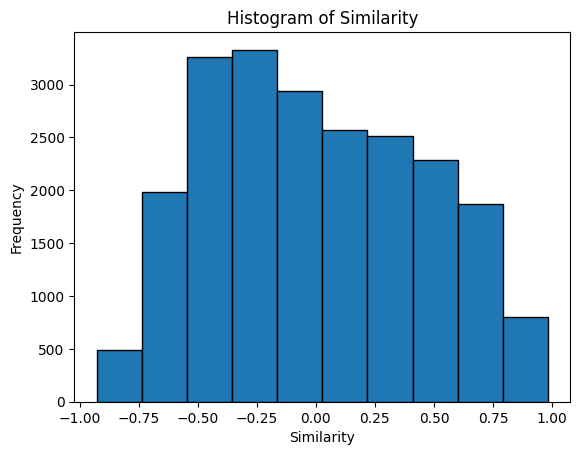

In [71]:
import matplotlib.pyplot as plt

# Plot histogram
plt.hist(merged_B['similarity'], bins=10, edgecolor='black')

# Add labels and title
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title('Histogram of Similarity')

# Show the plot
plt.show()

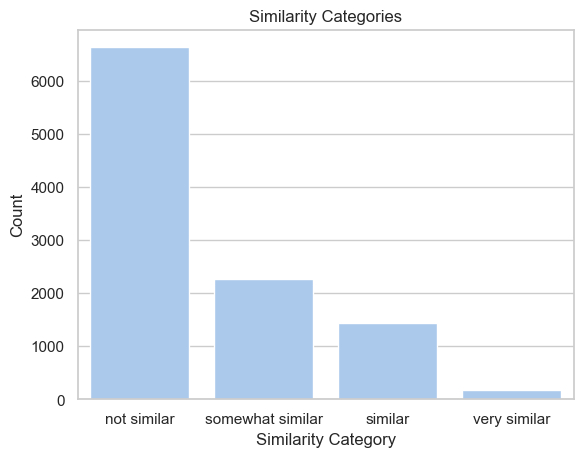

In [102]:
import seaborn as sns

import matplotlib.pyplot as plt

# Count the occurrences of each category
category_counts = merged_B['category'].value_counts()

# Set the style of the plot
sns.set(style="whitegrid")

# Set the color palette to light blue
sns.set_palette("pastel")

# Plot the bar graph
sns.barplot(x=category_counts.index, y=category_counts.values)

# Add labels and title
plt.xlabel('Similarity Category')
plt.ylabel('Count')
plt.title('Similarity Categories')

# Set x label rotation to 0
plt.xticks(rotation=0)

# Show the plot
plt.show()

In [99]:
given_county = 'AL_001'  # Replace with the ID of the given county

similar_counties = merged_B[merged_B['id_1'] == given_county].sort_values('similarity', ascending=False)
example_similarity = similar_counties[(similar_counties['category'] == 'similar') | (similar_counties['category'] == 'very similar')]
example_similarity.head(10)

,id_1,id_2,similarity,id_A,county_code_A,county_name_A,state_code_A,state_name_A,id_B,county_code_B,county_name_B,state_code_B,state_name_B,category
477,AL_001,MS_003,0.842619,AL_001,1,Autauga County,1,Alabama,MS_003,3,Alcorn County,28,Mississippi,similar
667,AL_001,LA_001,0.807698,AL_001,1,Autauga County,1,Alabama,LA_001,1,Acadia Parish,22,Louisiana,similar
717,AL_001,LA_009,0.799981,AL_001,1,Autauga County,1,Alabama,LA_009,9,Avoyelles Parish,22,Louisiana,similar
806,AL_001,AR_003,0.790939,AL_001,1,Autauga County,1,Alabama,AR_003,3,Ashley County,5,Arkansas,similar
836,AL_001,MS_007,0.788605,AL_001,1,Autauga County,1,Alabama,MS_007,7,Attala County,28,Mississippi,similar
868,AL_001,TX_005,0.784410,AL_001,1,Autauga County,1,Alabama,TX_005,5,Angelina County,48,Texas,similar
1026,AL_001,AR_005,0.764444,AL_001,1,Autauga County,1,Alabama,AR_005,5,Baxter County,5,Arkansas,similar
1037,AL_001,VA_001,0.763820,AL_001,1,Autauga County,1,Alabama,VA_001,1,Accomack County,51,Virginia,similar
1168,AL_001,SC_009,0.748437,AL_001,1,Autauga County,1,Alabama,SC_009,9,Bamberg County,45,South Carolina,similar
1212,AL_001,AL_009,0.742840,AL_001,1,Autauga County,1,Alabama,AL_009,9,Blount County,1,Alabama,similar


In [100]:
example_similarity.to_csv('/Users/judithyemeli/Documents/CSE_6242/Project/MVR/network_graph/inputs_data/similarity_example.csv', index=False)

In [74]:
high_sim = merged_B[(merged_B['category'] == 'similar') | (merged_B['category'] == 'very similar')]
high_sim

,id_1,id_2,similarity,id_A,county_code_A,county_name_A,state_code_A,state_name_A,id_B,county_code_B,county_name_B,state_code_B,state_name_B,category
1,WV_005,WV_001,0.982010,WV_005,5,Boone County,54,West Virginia,WV_001,1,Barbour County,54,West Virginia,very similar
0,WV_001,WV_005,0.982010,WV_001,1,Barbour County,54,West Virginia,WV_005,5,Boone County,54,West Virginia,very similar
2,AR_003,MS_003,0.979938,AR_003,3,Ashley County,5,Arkansas,MS_003,3,Alcorn County,28,Mississippi,very similar
3,MS_003,AR_003,0.979938,MS_003,3,Alcorn County,28,Mississippi,AR_003,3,Ashley County,5,Arkansas,very similar
4,IA_009,IA_001,0.977880,IA_009,9,Audubon County,19,Iowa,IA_001,1,Adair County,19,Iowa,very similar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1603,AL_007,FL_007,0.700660,AL_007,7,Bibb County,1,Alabama,FL_007,7,Bradford County,12,Florida,similar
1604,NM_001,FL_009,0.700154,NM_001,1,Bernalillo County,35,New Mexico,FL_009,9,Brevard County,12,Florida,similar
1605,FL_009,NM_001,0.700154,FL_009,9,Brevard County,12,Florida,NM_001,1,Bernalillo County,35,New Mexico,similar
1607,ND_003,IL_001,0.700070,ND_003,3,Barnes County,38,North Dakota,IL_001,1,Adams County,17,Illinois,similar


In [103]:
high_sim.isna().sum()

id_1             0
id_2             0
similarity       0
id_A             0
county_code_A    0
county_name_A    0
state_code_A     0
state_name_A     0
id_B             0
county_code_B    0
county_name_B    0
state_code_B     0
state_name_B     0
category         0
dtype: int64

In [104]:
high_sim.to_csv('/Users/judithyemeli/Documents/CSE_6242/Project/MVR/network_graph/inputs_data/high_sim.csv', index=False)

In [ ]:
# top_similarity_pairs = pairs_with_similarity[(pairs_with_similarity['similarity'] > first_quartile) & (pairs_with_similarity['id_1'].str[:2] != pairs_with_similarity['id_2'].str[:2])]

In [79]:
top_similarity_pairs = high_sim[high_sim['county_name_A'] != high_sim['state_name_B']]
len(top_similarity_pairs)

1608

In [80]:
top_pairs_tableau = top_similarity_pairs.rename(columns={'id_1': 'Source ID', 'id_2': 'Target ID'})


In [81]:
top_pairs_tableau.to_csv('/Users/judithyemeli/Documents/CSE_6242/Project/MVR/network_graph/inputs_data/top_similarity_pairs.csv', index=False)

In [82]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_similarity_network(top_pairs):
    # Create a graph
    G = nx.Graph()
    
    # Add edges for the top pairs with similarity as weight
    for _, row in top_pairs.iterrows():
        G.add_edge(row['id_1'], row['id_2'], weight=row['similarity'])
    
    # Draw the network
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    nx.draw(G, pos, with_labels=True, node_size=50, font_size=8, edge_color=weights, edge_cmap=plt.cm.Blues)
    plt.title("Similarity Network of Top County Pairs")
    plt.show()

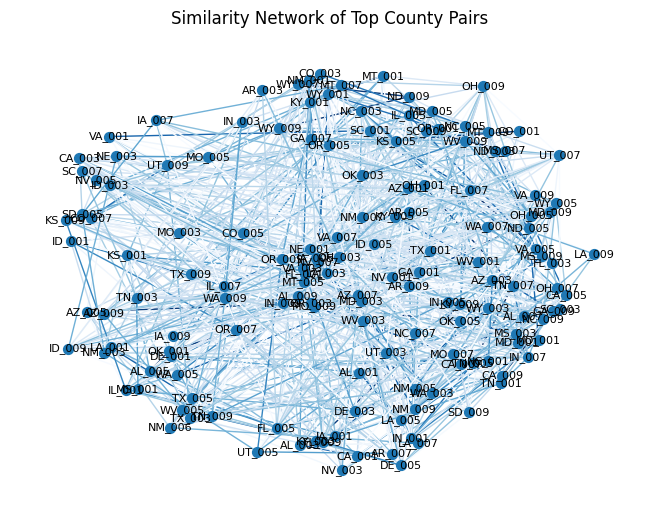

In [83]:
plot_similarity_network(top_pairs)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_similarity_network(top_pairs):
    # Create a graph
    G = nx.Graph()
    
    # Add edges for the top pairs with similarity as weight
    for _, row in top_pairs.iterrows():
        G.add_edge(row['id_1'], row['id_2'], weight=row['similarity'])
    
    # Draw the network
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]
    nx.draw(G, pos, with_labels=True, node_size=50, font_size=8, edge_color=weights, edge_cmap=plt.cm.Blues)
    plt.title("Similarity Network of Top County Pairs")
    plt.show()

In [ ]:
final_df.to_csv('final_df.csv', index=False)